In [147]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


In [148]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [149]:
filenames = os.listdir("train/train")

In [150]:
filenames[len(filenames)-10:]

['dog.9990.jpg',
 'dog.9991.jpg',
 'dog.9992.jpg',
 'dog.9993.jpg',
 'dog.9994.jpg',
 'dog.9995.jpg',
 'dog.9996.jpg',
 'dog.9997.jpg',
 'dog.9998.jpg',
 'dog.9999.jpg']

In [151]:
filenames[0].split(".")[0]

'cat'

In [152]:
categories = []
for filename in filenames:
    category = filename.split(".")[0]
    if category == "dog":
        categories.append(1)
    else:
        categories.append(0)

In [153]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [154]:
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


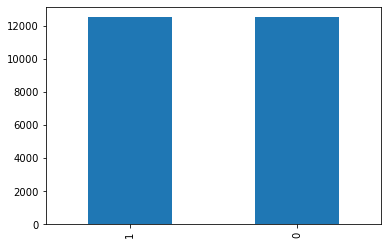

In [155]:
df['category'].value_counts().plot.bar()

In [156]:
sample = random.choice(filenames)

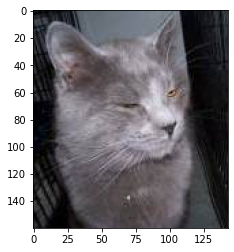

In [157]:
image=load_img("train/train/"+sample)
plt.imshow(image)

In [166]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)      

In [167]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [168]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau # 학습률을 줄이겠다, Platrau: 현 상황이 유지될때

In [169]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, # newlr := oldlr/2
                                            min_lr=0.00001)

In [170]:
callbacks = [earlystop, learning_rate_reduction]

In [172]:
df['category'] = df['category'].replace({0:'cat',1:'dog'})

In [174]:
df

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
...,...,...
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog


In [175]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [176]:
train_df.shape

(20000, 2)

In [177]:
validate_df.shape

(5000, 2)

In [178]:
train_df = train_df.reset_index(drop=True) # index drop
validate_df = validate_df.reset_index(drop=True)

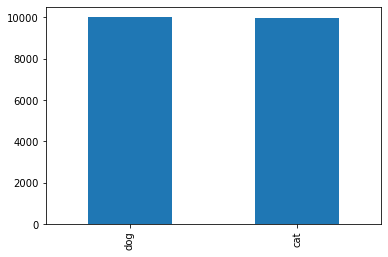

In [179]:
train_df['category'].value_counts().plot.bar()

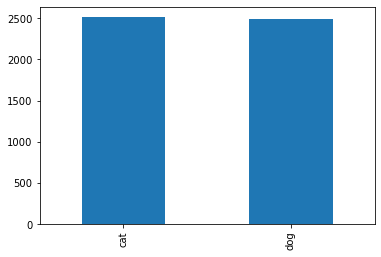

In [180]:
validate_df['category'].value_counts().plot.bar()

In [181]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [182]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [199]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "train/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [200]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


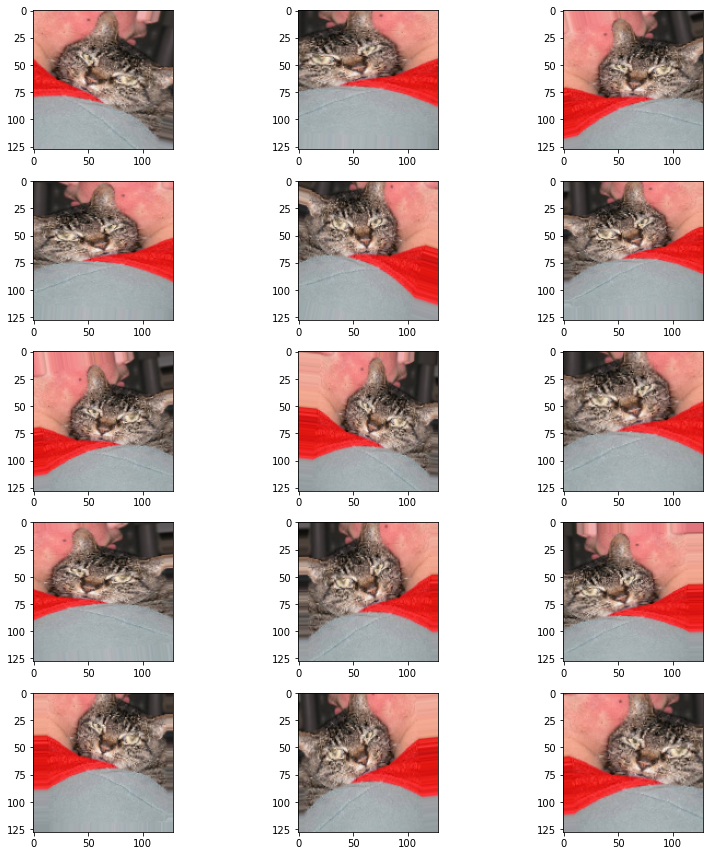

In [201]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [202]:
history = model.fit_generator(
    train_generator, 
    epochs=3,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
  98/1333 [=>............................] - ETA: 9:39 - loss: 1.3412 - acc: 0.5605

KeyboardInterrupt: 

In [ ]:
model.save

In [193]:
from keras.models import load_model

In [195]:
load_model('model.h5')

ValueError: No model found in config file.

In [203]:
test_filenames = os.listdir("test1/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [205]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [207]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size),verbose=1)

834/834 [==============================] - 59s 71ms/step


In [208]:
test_df['category'] = np.argmax(predict, axis=-1)

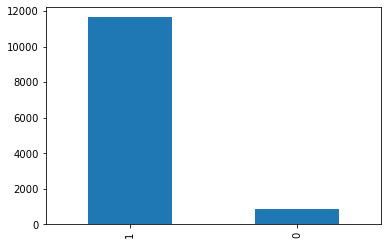

In [210]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
test_df['category'].value_counts().plot.bar()

In [16]:
# drop out : 모델 여러개를 쓰는 효과를 볼 수 있음.
from keras.datasets import boston_housing
# 보스턴 집값 median 예측
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

57344/57026 [==============================] - 0s 3us/step
(404, 13) (102, 13) (404,) (102,)


In [21]:
from keras.models import Sequential
from keras.layers import Activation, Dense
model = Sequential()
model.add(Dense(10, input_shape = (13,), activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(1))

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                140       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras import optimizers
sgd = optimizers.SGD(lr = 0.01)    # w:= w - alpha(learning rate) * (costFunction 편미분 값)
model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['mse'])  

In [24]:
model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1) # verbose 학습과정 출력 여부

Epoch 1/100
9/9 [==============================] - 0s 776us/step - loss: 353.1931 - mse: 353.1931
Epoch 2/100
9/9 [==============================] - 0s 884us/step - loss: 96.3104 - mse: 96.3104
Epoch 3/100
9/9 [==============================] - 0s 996us/step - loss: 84.4678 - mse: 84.4678
Epoch 4/100
9/9 [==============================] - 0s 997us/step - loss: 84.5752 - mse: 84.5752
Epoch 5/100
9/9 [==============================] - 0s 997us/step - loss: 84.2276 - mse: 84.2276
Epoch 6/100
9/9 [==============================] - 0s 890us/step - loss: 84.1879 - mse: 84.1879
Epoch 7/100
9/9 [==============================] - 0s 888us/step - loss: 83.8925 - mse: 83.8925
Epoch 8/100
9/9 [==============================] - 0s 997us/step - loss: 82.8557 - mse: 82.8557
Epoch 9/100
9/9 [==============================] - 0s 891us/step - loss: 84.3427 - mse: 84.3427
Epoch 10/100
9/9 [==============================] - 0s 900us/step - loss: 83.8895 - mse: 83.8895
Epoch 11/100
9/9 [===================

9/9 [==============================] - 0s 665us/step - loss: 77.6730 - mse: 77.6730
Epoch 86/100
9/9 [==============================] - 0s 1ms/step - loss: 77.9961 - mse: 77.9961
Epoch 87/100
9/9 [==============================] - 0s 776us/step - loss: 77.4183 - mse: 77.4183
Epoch 88/100
9/9 [==============================] - 0s 665us/step - loss: 78.5879 - mse: 78.5879
Epoch 89/100
9/9 [==============================] - ETA: 0s - loss: 79.2603 - mse: 79.260 - 0s 776us/step - loss: 77.7303 - mse: 77.7303
Epoch 90/100
9/9 [==============================] - 0s 554us/step - loss: 77.7110 - mse: 77.7110
Epoch 91/100
9/9 [==============================] - 0s 1ms/step - loss: 77.1066 - mse: 77.1066
Epoch 92/100
9/9 [==============================] - 0s 776us/step - loss: 77.6150 - mse: 77.6150
Epoch 93/100
9/9 [==============================] - 0s 665us/step - loss: 82.9123 - mse: 82.9123
Epoch 94/100
9/9 [==============================] - 0s 886us/step - loss: 77.9925 - mse: 77.9925
Epoch 9

In [25]:
results = model.evaluate(X_test, y_test)

print(model.metrics_names)     
print(results)                

print('loss: ', results[0])
print('mse: ', results[1])

4/4 [==============================] - 0s 1ms/step - loss: 81.9276 - mse: 81.9276
['loss', 'mse']
[81.9276351928711, 81.9276351928711]
loss:  81.9276351928711
mse:  81.9276351928711


In [27]:
# 분류 # 
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

whole_data = load_breast_cancer()
whole_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [28]:
whole_data = load_breast_cancer()
X_data = whole_data.data
y_data = whole_data.target

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 7) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(398, 30) (171, 30) (398,) (171,)


In [30]:
from keras.models import Sequential
model = Sequential()  

In [33]:
model = Sequential()
model.add(Dense(10, input_shape = (30,), activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [34]:
sgd = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['acc'])   

In [35]:
model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1)

Epoch 1/100
8/8 [==============================] - 0s 873us/step - loss: 0.7896 - acc: 0.4347
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6757 - acc: 0.6055
Epoch 3/100
8/8 [==============================] - 0s 996us/step - loss: 0.6709 - acc: 0.6055
Epoch 4/100
8/8 [==============================] - 0s 997us/step - loss: 0.6734 - acc: 0.6055
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6716 - acc: 0.6055
Epoch 6/100
8/8 [==============================] - 0s 997us/step - loss: 0.6716 - acc: 0.6055
Epoch 7/100
8/8 [==============================] - 0s 991us/step - loss: 0.6729 - acc: 0.6055
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6728 - acc: 0.6055
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6715 - acc: 0.6055
Epoch 10/100
8/8 [==============================] - 0s 997us/step - loss: 0.6715 - acc: 0.6055
Epoch 11/100
8/8 [==============================] - 0s 998us/step -

8/8 [==============================] - 0s 748us/step - loss: 0.6713 - acc: 0.6055
Epoch 89/100
8/8 [==============================] - 0s 747us/step - loss: 0.6721 - acc: 0.6055
Epoch 90/100
8/8 [==============================] - 0s 872us/step - loss: 0.6723 - acc: 0.6055
Epoch 91/100
8/8 [==============================] - 0s 873us/step - loss: 0.6717 - acc: 0.6055
Epoch 92/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6716 - acc: 0.6055
Epoch 93/100
8/8 [==============================] - 0s 869us/step - loss: 0.6738 - acc: 0.6055
Epoch 94/100
8/8 [==============================] - 0s 873us/step - loss: 0.6728 - acc: 0.6055
Epoch 95/100
8/8 [==============================] - ETA: 0s - loss: 0.7003 - acc: 0.540 - 0s 748us/step - loss: 0.6712 - acc: 0.6055
Epoch 96/100
8/8 [==============================] - 0s 872us/step - loss: 0.6715 - acc: 0.6055
Epoch 97/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6714 - acc: 0.6055
Epoch 98/100
8/8 [===========

In [36]:
results = model.evaluate(X_test, y_test)

print(model.metrics_names)     
print(results)                

print('loss: ', results[0])
print('mse: ', results[1])

6/6 [==============================] - 0s 832us/step - loss: 0.6392 - acc: 0.6784
['loss', 'acc']
[0.6391912698745728, 0.6783625483512878]
loss:  0.6391912698745728
mse:  0.6783625483512878


In [37]:
## 분류 (mnist)

In [55]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

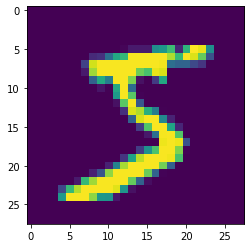

Label:  5


In [56]:
plt.imshow(X_train[0])  
plt.show()
print('Label: ', y_train[0])

In [57]:
X_train.shape

(60000, 28, 28)

In [58]:
y_train.shape

(60000,)

In [59]:
X_test.shape

(10000, 28, 28)

In [60]:
y_test.shape

(10000,)

In [61]:
# 다층 퍼셉트론은 1차원 벡터 형태로 데이터를 입력받음
# 28*28 -> 784 변경 후 입력
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

In [62]:
X_train.shape[0]
X_train = X_train.reshape((X_train.shape[0],-1))

In [63]:
X_test = X_test.reshape((X_test.shape[0],-1))

In [64]:
X_train, _ , y_train, _ = train_test_split(X_train, y_train, test_size = 0.67, random_state = 7)

In [65]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(19800, 784) (19800,) (10000, 784) (10000,)


In [66]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras import optimizers

model = Sequential()
model.add(Dense(50, input_shape = (784, )))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 50)                39250     
_________________________________________________________________
activation_21 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_22 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_23 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 50)              

In [67]:
sgd = optimizers.SGD(lr = 0.001)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, batch_size = 256, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100


ValueError: in user code:

    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


In [68]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()


NameError: name 'history' is not defined

In [ ]:
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])


In [ ]:
# 가중치 초기화
# default: 랜덤하게 가중치가 초기화됨(random_uniform)
# 르쿤 초기화 -> Xavier 초기화 -> He 초기화(resnet, 2015)

In [69]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# reshaping X data: (n, 28, 28) => (n, 784)
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

X_train, _ , y_train, _ = train_test_split(X_train, y_train, test_size = 0.67, random_state = 7)


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(19800, 784) (10000, 784) (19800, 10) (10000, 10)


In [79]:
def mlp_model():
    model = Sequential()
    model.add(Dense(50, input_shape = (784, ), 
                    kernel_initializer='he_normal')) # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(10, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [80]:
model = mlp_model()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100
434/434 [==============================] - 1s 2ms/step - loss: 4.5735 - accuracy: 0.4505 - val_loss: 1.3131 - val_accuracy: 0.5707
Epoch 2/100
434/434 [==============================] - 1s 2ms/step - loss: 1.0341 - accuracy: 0.6799 - val_loss: 0.9527 - val_accuracy: 0.6650
Epoch 3/100
434/434 [==============================] - 1s 2ms/step - loss: 0.7489 - accuracy: 0.7857 - val_loss: 0.7048 - val_accuracy: 0.8227
Epoch 4/100
434/434 [==============================] - 1s 2ms/step - loss: 0.5882 - accuracy: 0.8446 - val_loss: 0.6196 - val_accuracy: 0.8503
Epoch 5/100
434/434 [==============================] - 1s 2ms/step - loss: 0.5333 - accuracy: 0.8629 - val_loss: 0.5316 - val_accuracy: 0.8657
Epoch 6/100
434/434 [==============================] - 1s 2ms/step - loss: 0.4583 - accuracy: 0.8835 - val_loss: 0.4779 - val_accuracy: 0.8842
Epoch 7/100
434/434 [==============================] - 1s 2ms/step - loss: 0.4076 - accuracy: 0.8983 - val_loss: 0.4919 - val_accuracy: 0.8806

Epoch 58/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0709 - accuracy: 0.9815 - val_loss: 0.3289 - val_accuracy: 0.9362
Epoch 59/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0645 - accuracy: 0.9828 - val_loss: 0.4097 - val_accuracy: 0.9365
Epoch 60/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0817 - accuracy: 0.9788 - val_loss: 0.3667 - val_accuracy: 0.9384
Epoch 61/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0755 - accuracy: 0.9814 - val_loss: 0.3931 - val_accuracy: 0.9372
Epoch 62/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0669 - accuracy: 0.9825 - val_loss: 0.4260 - val_accuracy: 0.9360
Epoch 63/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0679 - accuracy: 0.9823 - val_loss: 0.3660 - val_accuracy: 0.9364
Epoch 64/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0627 - accuracy: 0.9838 - val_loss: 0.4482 - val_accuracy:

In [81]:
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

313/313 [==============================] - 0s 935us/step - loss: 0.4819 - accuracy: 0.9334
Test accuracy:  0.9333999752998352


In [82]:
# 배치 정규화 #
# 입력값 평균을 0, 분산을 1로 정규화한 네트워크 -> 학습이 잘 이루어짐(논문에서!)
from keras.layers import BatchNormalization
def mlp_model2():
    model = Sequential()
    model.add(Dense(50, input_shape = (784, ), 
                    kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dense(10, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [83]:
model = mlp_model2()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100
434/434 [==============================] - 1s 3ms/step - loss: 0.6755 - accuracy: 0.8093 - val_loss: 0.2842 - val_accuracy: 0.9199
Epoch 2/100
434/434 [==============================] - 1s 2ms/step - loss: 0.2962 - accuracy: 0.9117 - val_loss: 0.2062 - val_accuracy: 0.9370
Epoch 3/100
434/434 [==============================] - 1s 2ms/step - loss: 0.2233 - accuracy: 0.9320 - val_loss: 0.1814 - val_accuracy: 0.9453
Epoch 4/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1851 - accuracy: 0.9416 - val_loss: 0.1660 - val_accuracy: 0.9485
Epoch 5/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1494 - accuracy: 0.9550 - val_loss: 0.1579 - val_accuracy: 0.9525
Epoch 6/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1493 - accuracy: 0.9535 - val_loss: 0.1651 - val_accuracy: 0.9493
Epoch 7/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1279 - accuracy: 0.9612 - val_loss: 0.1590 - val_accuracy: 0.9529

Epoch 58/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0184 - accuracy: 0.9937 - val_loss: 0.1693 - val_accuracy: 0.9618
Epoch 59/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.1686 - val_accuracy: 0.9628
Epoch 60/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0249 - accuracy: 0.9913 - val_loss: 0.1829 - val_accuracy: 0.9593
Epoch 61/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0161 - accuracy: 0.9950 - val_loss: 0.1726 - val_accuracy: 0.9635
Epoch 62/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0273 - accuracy: 0.9908 - val_loss: 0.1668 - val_accuracy: 0.9613
Epoch 63/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0300 - accuracy: 0.9911 - val_loss: 0.1758 - val_accuracy: 0.9626
Epoch 64/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0247 - accuracy: 0.9913 - val_loss: 0.1791 - val_accuracy:

In [84]:
# 여기에 앙상블, dropout까지 더하면 정말 성능이 더 좋아질 수 있다.
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

313/313 [==============================] - 0s 943us/step - loss: 0.1928 - accuracy: 0.9651
Test accuracy:  0.9650999903678894


In [85]:
## drop out 추가 ##
from keras.layers import Dropout
def mlp_model3():
    model = Sequential()
    model.add(Dense(50, input_shape = (784, ), 
                    kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))   
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [86]:
model = mlp_model3()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100
434/434 [==============================] - 1s 3ms/step - loss: 1.3108 - accuracy: 0.5759 - val_loss: 0.4415 - val_accuracy: 0.8747
Epoch 2/100
434/434 [==============================] - 1s 3ms/step - loss: 0.6971 - accuracy: 0.7897 - val_loss: 0.3016 - val_accuracy: 0.9125
Epoch 3/100
434/434 [==============================] - 1s 3ms/step - loss: 0.5689 - accuracy: 0.8348 - val_loss: 0.2624 - val_accuracy: 0.9219
Epoch 4/100
434/434 [==============================] - 1s 3ms/step - loss: 0.5024 - accuracy: 0.8539 - val_loss: 0.2332 - val_accuracy: 0.9298
Epoch 5/100
434/434 [==============================] - 1s 3ms/step - loss: 0.4699 - accuracy: 0.8646 - val_loss: 0.2276 - val_accuracy: 0.9320
Epoch 6/100
434/434 [==============================] - 1s 3ms/step - loss: 0.4205 - accuracy: 0.8784 - val_loss: 0.1948 - val_accuracy: 0.9444
Epoch 7/100
434/434 [==============================] - 1s 3ms/step - loss: 0.3906 - accuracy: 0.8834 - val_loss: 0.1887 - val_accuracy: 0.9441

Epoch 58/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1664 - accuracy: 0.9496 - val_loss: 0.1405 - val_accuracy: 0.9601
Epoch 59/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1531 - accuracy: 0.9551 - val_loss: 0.1365 - val_accuracy: 0.9604
Epoch 60/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1550 - accuracy: 0.9545 - val_loss: 0.1371 - val_accuracy: 0.9618
Epoch 61/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1757 - accuracy: 0.9465 - val_loss: 0.1344 - val_accuracy: 0.9626
Epoch 62/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1649 - accuracy: 0.9494 - val_loss: 0.1340 - val_accuracy: 0.9641
Epoch 63/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1587 - accuracy: 0.9548 - val_loss: 0.1310 - val_accuracy: 0.9640
Epoch 64/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1522 - accuracy: 0.9545 - val_loss: 0.1328 - val_accuracy:

In [87]:
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

313/313 [==============================] - 0s 945us/step - loss: 0.1353 - accuracy: 0.9635
Test accuracy:  0.9635000228881836


In [88]:
# 앙상블 기법 추가 #
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [90]:
def mlp_model4():
    model = Sequential()
    model.add(Dense(50, input_shape = (784, ), 
                    kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))   
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer='he_normal')) # use he_normal initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [91]:
model1 = KerasClassifier(build_fn=mlp_model4,epochs=100,verbose=1)
model2 = KerasClassifier(build_fn=mlp_model4,epochs=100,verbose=1)
model3 = KerasClassifier(build_fn=mlp_model4,epochs=100,verbose=1)

In [93]:
ens_clf = VotingClassifier(estimators=[
    ('model1',model1),('model2',model2),('model3',model3)],
                           voting='soft')

In [94]:
ens_clf.fit(X_train,y_train)

NotImplementedError: Multilabel and multi-output classification is not supported.

In [130]:
from keras.layers import Conv2D,MaxPooling2D, Flatten
model = Sequential()
model.add(Conv2D(input_shape = (10, 10, 3), filters = 10, kernel_size = (3,3), strides = (1,1), 
                 padding = 'valid'))
print(model.output_shape)


(None, 8, 8, 10)


In [97]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [98]:
data = datasets.load_digits()

In [103]:
# 1797개 숫자 이미지, 각 숫자 이미지의 shape은 8,8
data.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [104]:
data.target

array([0, 1, 2, ..., 8, 9, 8])

In [107]:
X_data=data.images

In [108]:
y_data=data.target

In [109]:
X_data.shape

(1797, 8, 8)

In [110]:
y_data.shape

(1797,)

In [112]:
X_data = X_data.reshape((X_data.shape[0],X_data.shape[1],X_data.shape[2],1))

In [113]:
y_data = to_categorical(y_data) # one-hot encoding

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 777)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1257, 8, 8, 1)
(540, 8, 8, 1)
(1257, 10)
(540, 10)


In [115]:
from keras.datasets import cifar10

In [116]:
(xtrain,ytrain),_ = cifar10.load_data()

170500096/170498071 [==============================] - 29s 0us/step


In [117]:
xtrain.shape # (50000, 32, 32, 3)

(50000, 32, 32, 3)

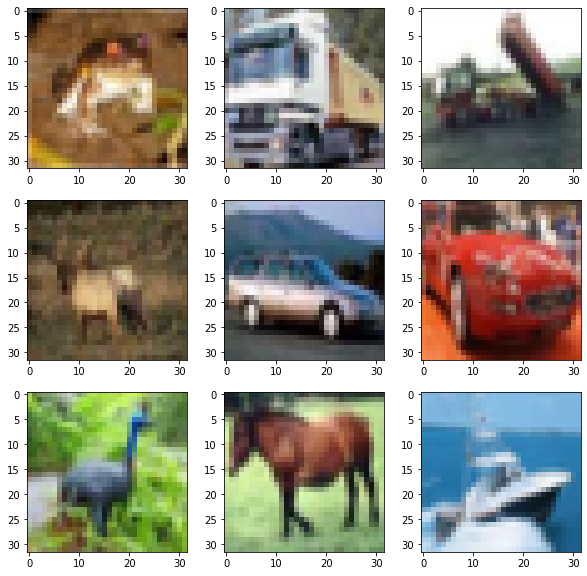

In [119]:
fig = plt.figure(figsize = (10, 10))
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(xtrain[i])
plt.show()


In [131]:
model = Sequential()
model.add(Conv2D(input_shape = (10, 10, 3), filters = 20, kernel_size = (3,3), 
                 strides = (1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
print(model.output_shape)

(None, 500)


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 777)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1257, 8, 8, 1)
(540, 8, 8, 1)
(1257, 10)
(540, 10)


In [136]:
model = Sequential()
model.add(Conv2D(input_shape = (X_data.shape[1], X_data.shape[2], X_data.shape[3]), 
                 filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 6, 6, 10)          100       
_________________________________________________________________
activation_61 (Activation)   (None, 6, 6, 10)          0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 50)                4550      
_________________________________________________________________
dense_76 (Dense)             (None, 10)                510       
Total params: 5,160
Trainable params: 5,160
Non-trainable params: 0
___________________________________________________

In [137]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [138]:
history = model.fit(X_train, y_train, batch_size = 50, validation_split = 0.2, epochs = 100, verbose = 1)

Epoch 1/100
21/21 [==============================] - 0s 11ms/step - loss: 2.9842 - accuracy: 0.2060 - val_loss: 1.8403 - val_accuracy: 0.3651
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 1.3648 - accuracy: 0.5512 - val_loss: 1.0079 - val_accuracy: 0.7103
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.8228 - accuracy: 0.7721 - val_loss: 0.6531 - val_accuracy: 0.8016
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5665 - accuracy: 0.8408 - val_loss: 0.4435 - val_accuracy: 0.8730
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4323 - accuracy: 0.8726 - val_loss: 0.3402 - val_accuracy: 0.8968
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3349 - accuracy: 0.9055 - val_loss: 0.2829 - val_accuracy: 0.9206
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.2754 - accuracy: 0.9294 - val_loss: 0.2301 - val_accuracy: 0.9444
Epoch 8/100


Epoch 59/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 0.9802
Epoch 60/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 0.9802
Epoch 61/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9802
Epoch 62/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 0.9802
Epoch 63/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9802
Epoch 64/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 0.9802
Epoch 65/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0547 - val_accuracy: 0.9802
Epoch 

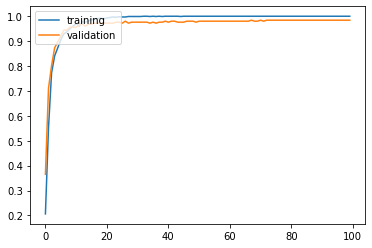

In [140]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()


In [141]:
results = model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 1ms/step - loss: 0.0983 - accuracy: 0.9759


In [142]:
results

[0.09825742244720459, 0.9759259223937988]

In [143]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshaping X data: (n, 28, 28) => (n, 28, 28, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
# converting y data into categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


In [144]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

def basic_cnn():
    model = Sequential()

    model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    # prior layer should be flattend to be connected to dense layers
    model.add(Flatten())
    # dense layer with 50 neurons
    model.add(Dense(50, activation = 'relu'))
    # final layer with 10 neurons to classify the instances
    model.add(Dense(10, activation = 'softmax'))

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

model = basic_cnn()
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 50)        500       
_________________________________________________________________
activation_62 (Activation)   (None, 28, 28, 50)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 50)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9800)              0         
_________________________________________________________________
dense_77 (Dense)             (None, 50)                490050    
_________________________________________________________________
dense_78 (Dense)             (None, 10)                510       
Total params: 491,060
Trainable params: 491,060
Non-trainable params: 0
_______________________________________________

In [146]:
history = model.fit(X_train, y_train, batch_size = 50, validation_split = 0.2, epochs = 100, verbose = 1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()


Epoch 1/100
960/960 [==============================] - 19s 20ms/step - loss: 0.2004 - accuracy: 0.9506 - val_loss: 0.1178 - val_accuracy: 0.9729
Epoch 2/100
960/960 [==============================] - 19s 19ms/step - loss: 0.0915 - accuracy: 0.9750 - val_loss: 0.1048 - val_accuracy: 0.9751
Epoch 3/100
960/960 [==============================] - 17s 18ms/step - loss: 0.0586 - accuracy: 0.9827 - val_loss: 0.0945 - val_accuracy: 0.9773
Epoch 4/100
960/960 [==============================] - 18s 19ms/step - loss: 0.0425 - accuracy: 0.9869 - val_loss: 0.1054 - val_accuracy: 0.9772
Epoch 5/100
960/960 [==============================] - 19s 20ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.1002 - val_accuracy: 0.9777
Epoch 6/100
960/960 [==============================] - 19s 20ms/step - loss: 0.0296 - accuracy: 0.9912 - val_loss: 0.0991 - val_accuracy: 0.9778
Epoch 7/100
960/960 [==============================] - 19s 20ms/step - loss: 0.0257 - accuracy: 0.9918 - val_loss: 0.1022 - val_ac

KeyboardInterrupt: 

In [ ]:
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])